# Feedback filters
```{eval-rst}
.. index:: filter; feedback
```

The systems we've studied so far (e.g., convolutional filters) are **feed-forward** systems: each output $y[n]$ depends only on the input signal $x$ (and the parameters of the filter).
A **feedback** system is one where each output $y[n]$ can also depend on **previous outputs**.
The situation is analogous to the feedback encountered by placing a microphone (or, perhaps, an electric guitar) close to its speaker, creating a closed loop that results in resonance, like the example below.

In [1]:
%run ../setup.ipynb

Feedback systems can be powerful, but need to be treated with care.
If you place a microphone *too close* to an amplifier's output, the system can become unstable and damage its components, as well as the eardrums of anyone who happens to be nearby.

## Example: exponential moving average
```{eval-rst}
.. index:: filter; exponential moving average
```
As an introduction to feedback filters, let's imagine the following process for computing a moving average of a signal $\blue{x[n]}$, resulting in output signal $\purple{y[n]}$:

```{math}
:label: ema

\purple{y[n]} = \red{\frac{1}{2}} \cdot x[n] + \cyan{\frac{1}{2}} \cdot \purple{y[n-1]}.
```

This is a **feedback** process because the output $\purple{y[n]}$ depends on both the input $\blue{x[n]}$ (a feed-forward process) and the **previous output** $\purple{y[n-1]}$ (feedback).
Here, we'll take the convention that $\purple{y[-1] = 0}$, so the first output $\purple{y[0]} = \red{\frac{1}{2}} \cdot \blue{x[0]}$.
An example of this process is illustrated below in {numref}`iir`.

<Figure size 432x288 with 2 Axes>

<Figure size 432x288 with 2 Axes>

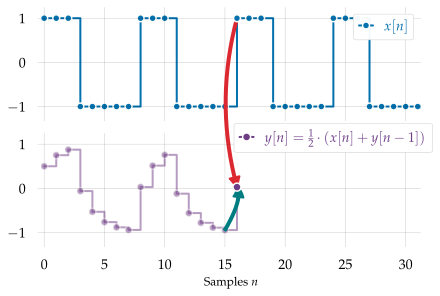

In [3]:
from matplotlib.patches import ConnectionPatch

fig, (axin, axout) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 4))

N = 32

n = np.arange(N)
x = scipy.signal.square(2 * np.pi * 4 * n / N, duty=1./3)
b = [1/2]
a = [1, -1/2]
y = scipy.signal.lfilter(b, a, x)

axin.step(n, x, where='post', marker='o', zorder=-1, color=colors[0])
xp = axin.step(n, x, where='post', marker='o', label='$x[n]$', color=colors[0])[0]
yp2 = axout.step(n, y, where='post', marker='o', color=colors[4], zorder=-1, alpha=0.5)[0]
yp = axout.step(n, y, where='post', marker='o', markersize=8, color=colors[4], 
                    label=r'$y[n] = \frac{1}{2} \cdot \left(x[n] + y[n-1]\right)$')[0]

r1 = ConnectionPatch((n[0], x[0]), (n[0], y[0]),
                         coordsA="data", coordsB="data",
                         axesA=axin, axesB=axout, color=colors[1],
                         linewidth=2,
                         connectionstyle="angle3,angleA=75,angleB=-75", 
                         arrowstyle='simple, head_width=1, head_length=1')
r1.set_in_layout(False)
axin.add_patch(r1)

r2 = ConnectionPatch((n[0], y[0]), (n[1], y[1]),
                         coordsA="data", coordsB="data",
                         axesA=axout, axesB=axout, color=colors[7],
                         linewidth=2,
                         connectionstyle="angle3,angleA=60,angleB=-60", 
                         arrowstyle='simple, head_width=1, head_length=1')
r2.set_in_layout(False)
r2.set_visible(False)
axout.add_patch(r2)

axin.legend(loc='upper right', labelcolor='linecolor')
axout.legend(loc='upper right', labelcolor='linecolor', bbox_to_anchor=(1.05, 1.15))
axout.set(xlim=[-0.25, N-0.75], ylim=[-1.25, 1.25])
axin.label_outer()
axout.set(xlabel='Samples $n$')

def init():
    return xp, yp, yp2, r1, r2

def animate(i):
    
    if i > 0:
        r2.set_visible(True)
    else:
        r2.set_visible(False)
        
    
    xp.set_data(n[i:i+1], x[i:i+1])
    yp.set_data(n[i:i+1], y[i:i+1])
    yp2.set_data(n[:i+1], y[:i+1])
    r1.xy1 = (n[i], x[i])
    r1.xy2 = (n[i], y[i])
    r2.xy1 = (n[i-1], y[i-1])
    r2.xy2 = (n[i], y[i])
        
    if i >= N - 1:
        xp.set_data(n, x)
        yp.set_data(n, y)
        yp2.set_data(n, y)
        
    return xp, yp, yp2, r1, r2

#animation = FuncAnimation(fig, animate, frames=N, init_func=init, interval=0.75 * 1000, blit=True)
#glue('iir', animation, display=False)
animate(N//2)
glue('iir', fig, display=False)

```{glue:figure} iir
:name: iir

**Top**: an input signal $\blue{x[n]}$.
**Bottom**: the output $\purple{y[n]}$ of an exponential moving average filter {eq}`ema` combines the current input sample $\blue{x[n]}$ with the previous output sample $\purple{y[n-1]}$ (*arrows*).
```

Just like we did with {ref}`convolutional filters <impulse-response>`, we can try to understand the behavior of {eq}`ema` by providing an impulse signal as input $\blue{x = [1, 0, 0, \dots]}$ and seeing how the system responds:

\begin{align*}
\blue{x[0]} &= \blue{1} &\Rightarrow \purple{y[0]} &= \purple{1/2}\\
\blue{x[1]} &= \blue{0} &\Rightarrow \purple{y[1]} &= \purple{1/2 \cdot y[0] = 1/4}\\
\blue{x[2]} &= \blue{0} &\Rightarrow \purple{y[2]} &= \purple{1/2 \cdot y[1] = 1/8}\\
\blue{x[3]} &= \blue{0} &\Rightarrow \purple{y[3]} &= \purple{1/2 \cdot y[2] = 1/16}\\
&&\dots&&\\
&& \purple{y[n]} &= \purple{2^{-(n+1)}}
\end{align*}

This shows that the impulse response, illustrated below in {numref}`iir-response`, decays *exponentially* (hence the name: *exponential moving average*).
However, there is no finite length $N$ for which all $n \geq N$ satisfy $\purple{y[n] = 0}$: the impulse response is **infinitely long**.
This is where the term **infinite impulse response (IIR)** filter comes from.

<Figure size 432x144 with 1 Axes>

<Figure size 432x144 with 1 Axes>

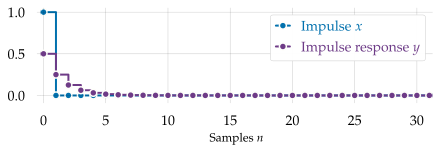

In [15]:
fig, axin = plt.subplots(sharex=True, sharey=True, figsize=figaspect(1./3))

N = 32

n = np.arange(N)
x = np.zeros(N)
x[0] = 1
b = [1/2]
a = [1, -1/2]
y = scipy.signal.lfilter(b, a, x)

axin.step(n, x, where='post', marker='o', zorder=-1, color=colors[0], label='Impulse $x$')
axin.step(n, y, where='post', marker='o', color=colors[4], label=r'Impulse response $y$')

axin.legend(loc='upper right', labelcolor='linecolor')
axin.set(xlim=[-0.25, N-0.75], ylim=[-.05, 1.05])
axin.label_outer()
axin.set(xlabel='Samples $n$')

glue('iir-response', fig, display=False)

```{glue:figure} iir-response
:name: iir-response
:alt: impulse response of an exponential moving average filter

The impulse response of {eq}`ema` decays exponentially: $\purple{y[n] = 2^{-(n+1)}}$, but never reaches 0.
```

## IIR Filters
```{eval-rst}
.. index:: !IIR, !Infinite Impulse Response, impulse response; infinite, filter; IIR
```
The example above is one of the simplest non-trivial feedback systems we could write down, but its behavior is far from simple.

Generalizing the idea of incorporating previous outputs to compute the next output leads to the following standard definition of an IIR filter.

````{prf:definition} Linear IIR filter

A **linear IIR filter** consists of two sets of parameters:
the **feed-forward** parameters $\red{b = [b_0, b_1, \dots, b_{K-1}]}$, 
and the **feed-back** parameters $\cyan{a = [a_0, a_1, \dots, a_{K-1}]}$.

Given an input signal $\blue{x}$, the output is computed according to the following equation:

```{math}
:label: iir

\cyan{a[0]} \cdot \purple{y[n]} = \sum_{k=0}^{K-1} \red{b[k]} \cdot \blue{x[n-k]} - \sum_{k=1}^{K-1} \cyan{a[k]} \cdot \purple{y[n-k]}.
```
````


```{margin} Feed-forward and feed-back?
At this point, you might be wondering why the feed-back parameters are called $\cyan{a}$ and the feed-forward parameters are called $\red{b}$.
One would think that $\red{b}$ is for **back**, right?

Alas, this notation is traditional, and standard across nearly all signal processing frameworks.

One way to remember this convention is:

- $\red{b}$ for **before** the filter is applied,
- $\cyan{a}$ for **after** the filter is applied.

```

There's much to unpack in this definition, but it's not as scary as it may seem.
Let's look at a couple of special cases before moving on.

## Special case 1: $a[0] = 1$

Note in {eq}`iir` that the feed-back summation starts at $k=1$, and the first feedback coefficient $\cyan{a[0]}$ appears on the left-hand side of the equation.
This is an admittedly annoying bit of notation, but it is so pervasively used that we'll stick with it.
The idea here is that if the summation started at $k=0$, then $\purple{y[n]}$ would depend on itself: $\purple{y[n-0] = y[n]}$.
Keeping the $k=0$ feedback term separate lets us define $\purple{y[n]}$ without any such circular dependencies.

As long as $\cyan{a[0] \neq 0}$, we can divide through on both sides to get an equation that isolates the output $\purple{y[n]}$ in terms of the inputs:

```{math}
\purple{y[n]} = \cyan{\frac{1}{a[0]}} \cdot \left({\sum_{k=0}^{K-1} \red{b[k]} \cdot \blue{x[n-k]} - \sum_{k=1}^{K-1} \cyan{a[k]} \cdot \purple{y[n-k]}}\right).
```

In code, this could be implemented as follows to compute the first $N$ output samples:

(iir-function)=
```{code-block} python
def filter(b, a, x):
    '''Apply a linear IIR system defined by b and a to a signal x.
    
    b and a must have the same length, and a[0] cannot be 0.
    '''
    # Allocate N output samples
    N = len(x)
    y = np.zeros(N)
    
    K = len(b)  # Get the order of the filter
    
    # Compute each output y[n] in sequence
    for n in range(N):        
        for k in range(min(K, n)):  # Add the feed-forward part
            y[n] += b[k] * x[n-k]
        for k in range(1, min(K, n)):  # Subtract the feed-back part
            y[n] -= a[k] * y[n-k]
        y[n] /= a[0]  # Divide through by a[0]
    return y
```

When $\cyan{a[0]} = 1$, this leading factor of $\cyan{1/a[0]}$ disappears, and we're left with the equation

```{math}
\purple{y[n]} = \sum_{k=0}^{K-1} \red{b[k]} \cdot \blue{x[n-k]} - \sum_{k=1}^{K-1} \cyan{a[k]} \cdot \purple{y[n-k]}.
```

This case is particularly common, because we can always replace the coefficients $\red{b[k]}$ by $\red{b[k]} / \cyan{a[0]}$ (and $\cyan{a[k]}$ by $\cyan{a[k] / a[0]}$) without changing the behavior of the system.
In many implementations, it therefore always assumed that $\cyan{a[0] = 1}$.

Returning to the first example, we can implement {eq}`ema` with the following coefficients:

\begin{align*}
\red{b} &= \red{\left[\frac{1}{2} \right]}\\
\cyan{a} &= \cyan{\left[1, -\frac{1}{2} \right]}.
\end{align*}

## Special case 2: $a[k] = 0$

If all of the feedback coefficients $\cyan{a[k>0] = 0}$, and $\cyan{a[0] = 1}$ as above, then the IIR definition {eq}`iir` simplifies to a *standard convolution*:

```{math}
\purple{y[n]} = \sum_{k=0}^{K-1} \red{b[k]} \cdot \blue{x[n-k]}.
```

FIR filters, therefore, are a special case of IIR filters.
Everything we develop with IIR filters can also be applied to FIR filters.

## Causal filters
```{eval-rst}
.. index:: filter; causal
```
All of the IIR filters that we'll encounter define the output $\purple{y[n]}$ in terms of inputs up to $\blue{x[n]}$ and previous outputs up to (and including) $\purple{y[n-1]}$.
Note that $\purple{y[n]}$ does not depend on $\blue{x[n+1]}$, or on $\purple{y[n+1]}$.

Systems with this property are known as **causal systems**.
It is also possible to have *non-causal* systems, where the output at sample index $n$ can depend on future inputs like $\blue{x[n+1]}$.
This might sound strange, but we'll see later in this chapter that there are sometimes good reasons to use non-causal filters.

## Why are feedbacks subtracted instead of added?

Another apparently strange quirk of IIR notation is that the feed-forward sum is *added*, but the feed-back sum is *subtracted*.
On a first glance, this seems arbitrary and weird, and often leads to mistakes in implementation.

The true reason for this convention will become apparent in the next chapter, when we cover the *z-Transform*.
For now, it may be helpful to think about what would happen if we tried to isolate all of the $y$ terms on one side of the equation, and the $x$ terms on the other:

```{math}
:label: iir-symmetry

\sum_{k=0}^{K-1} \cyan{a[k]} \cdot \purple{y[n-k]} = \sum_{k=0}^{K-1} \red{b[k]} \cdot \blue{x[n-k]}.
```

The key benefit of subtracting the feedback terms, rather than adding them, is that when we isolate $\purple{y}$ from $\blue{x}$ as in {eq}`iir-symmetry`, all terms appear *positively*.
Although this form cannot be used directly to compute each output $\purple{y[n]}$, it will help prevent sign errors and generally make our lives easier later on when we develop the $z$-Transform.

## Summary

The use of feedback can be a conceptual leap for many people, so let's now pause and take stock of what we've seen so far.

- Feedback systems can have an infinite impulse response, even when the input is finite in length.
- We can always assume the first feedback coefficient $\cyan{a[0] = 1}$.
- IIR filters generalize FIR filters.
- The feed-back terms are subtracted, not added, to produce each output $\purple{y[n]}$.
- In general, $\red{b}$ and $\cyan{a}$ need not be the same length, but we can always pad the shorter of the two with zeros to make them match.

With these facts in mind, we can now proceed to trying out some examples.